In [1]:
import pandas as pd
import numpy as np

In [2]:
strava_activities = pd.read_csv('activities.csv')

In [3]:
strava_activities.head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,UV Index,Weather Ozone,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>"
0,350128633,"Jul 20, 2015, 1:06:57 PM",Renecca creek rd,Ride,NaN,2352,13.48,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,623600149,"Oct 11, 2015, 10:03:14 PM",Afternoon Ride,Ride,NaN,5495,23.61,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,797001969,"Dec 8, 2016, 4:28:12 PM",Morning Ride,Ride,NaN,8,0.03,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,800888948,"Dec 12, 2016, 10:22:44 PM",Afternoon Ride,Ride,NaN,7942,10.22,149.0,8.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,811340614,"Dec 25, 2016, 10:37:32 PM",Afternoon Ride,Ride,NaN,4983,26.16,162.0,32.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# strava_activities.columns

## There's actually not a lot of interesting stuff here--I'm shifting my focus to the raw gpx files and see how I can compile, clean and use them in Tableau

In [5]:
test = pd.read_csv('strava_test.gpx')

In [6]:
test

,"<?xml version=""1.0"" encoding=""UTF-8""?>"
0,"<gpx creator=""StravaGPX iPhone"" xmlns:xsi=""htt..."
1,<metadata>
2,<time>2015-07-20T13:06:57Z</time>
3,</metadata>
4,<trk>
...,...
8442,<time>2015-07-20T13:46:08Z</time>
8443,</trkpt>
8444,</trkseg>
8445,</trk>


## this is what a raw gpx for one single activity looks like if we read it as if it were a csv

In [7]:
# pip instal gpxpy
# This is a gpx parser library
import gpxpy
import pandas as pd

# Load gpx.
gpx_path = 'strava_test.gpx'
with open(gpx_path) as f:
    gpx = gpxpy.parse(f)

In [8]:
gpx

GPX(tracks=[GPXTrack(name='Renecca creek rd', segments=[GPXTrackSegment(points=[...])])])

In [9]:
# Convert to a dataframe one point at a time.
points = []
for segment in gpx.tracks[0].segments:
    for p in segment.points:
        points.append({
            'time': p.time,
            'latitude': p.latitude,
            'longitude': p.longitude,
            'elevation': p.elevation,
        })
df = pd.DataFrame.from_records(points)

In [10]:
df

,time,latitude,longitude,elevation
0,2015-07-20 13:06:57+00:00,29.910366,-98.352775,303.4
1,2015-07-20 13:08:26+00:00,29.910346,-98.352775,303.4
2,2015-07-20 13:08:28+00:00,29.910353,-98.352738,303.3
3,2015-07-20 13:08:30+00:00,29.910365,-98.352685,303.2
4,2015-07-20 13:08:32+00:00,29.910365,-98.352626,303.0
...,...,...,...,...
2104,2015-07-20 13:45:52+00:00,29.816008,-98.342002,400.4
2105,2015-07-20 13:45:53+00:00,29.815966,-98.341999,400.6
2106,2015-07-20 13:45:54+00:00,29.815918,-98.341995,400.9
2107,2015-07-20 13:45:59+00:00,29.815889,-98.341993,401.1


In [11]:
# pip install geopy
# a library for geographical data
import geopy.distance


# Cumulative distance.
coords = [(p.latitude, p.longitude) for p in df.itertuples()]
df['distance'] = [0] + [geopy.distance.distance(from_, to).m for from_, to in zip(coords[:-1], coords[1:])]
df['cumulative_distance'] = df.distance.cumsum()


# Timing.
df['duration'] = df.time.diff().dt.total_seconds().fillna(0)
df['cumulative_duration'] = df.duration.cumsum()
df['pace_metric'] = pd.Series((df.duration / 60) / (df.distance / 1000)).bfill()

In [12]:
df

,time,latitude,longitude,elevation,distance,cumulative_distance,duration,cumulative_duration,pace_metric
0,2015-07-20 13:06:57+00:00,29.910366,-98.352775,303.4,0.000000,0.000000,0.0,0.0,669.066688
1,2015-07-20 13:08:26+00:00,29.910346,-98.352775,303.4,2.217019,2.217019,89.0,89.0,669.066688
2,2015-07-20 13:08:28+00:00,29.910353,-98.352738,303.3,3.656480,5.873498,2.0,91.0,9.116236
3,2015-07-20 13:08:30+00:00,29.910365,-98.352685,303.2,5.288393,11.161891,2.0,93.0,6.303112
4,2015-07-20 13:08:32+00:00,29.910365,-98.352626,303.0,5.697799,16.859691,2.0,95.0,5.850212
...,...,...,...,...,...,...,...,...,...
2104,2015-07-20 13:45:52+00:00,29.816008,-98.342002,400.4,5.777120,13462.015780,1.0,2335.0,2.884944
2105,2015-07-20 13:45:53+00:00,29.815966,-98.341999,400.6,4.664695,13466.680475,1.0,2336.0,3.572938
2106,2015-07-20 13:45:54+00:00,29.815918,-98.341995,400.9,5.334799,13472.015274,1.0,2337.0,3.124141
2107,2015-07-20 13:45:59+00:00,29.815889,-98.341993,401.1,3.220439,13475.235713,5.0,2342.0,25.876388


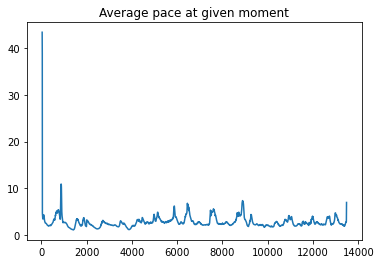

In [13]:
# pip install numpy_ext
# an extension of numpy features
from numpy_ext import rolling_apply
import matplotlib.pyplot as plt


def rolling_metric_pace(duration, distance):
    return (duration.sum() / 60) / (distance.sum() / 1000)


x = df.cumulative_distance
y = rolling_apply(rolling_metric_pace, 10, df.duration.values, df.distance.values)
plt.title("Average pace at given moment")
plt.plot(x, y)

<AxesSubplot:xlabel='cumulative_distance', ylabel='elevation'>

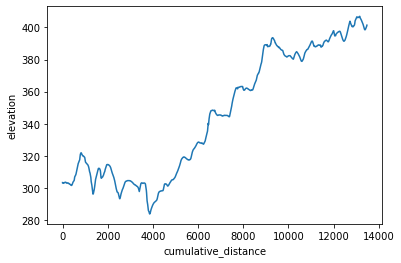

In [14]:
import seaborn as sns

sns.lineplot(data=df, x='cumulative_distance', y='elevation')

## Obviously, I have valid elevation data, and I will possibly wheel back around to attept a smoothing of it later.

In [15]:
df.head()

,time,latitude,longitude,elevation,distance,cumulative_distance,duration,cumulative_duration,pace_metric
0,2015-07-20 13:06:57+00:00,29.910366,-98.352775,303.4,0.000000,0.000000,0.0,0.0,669.066688
1,2015-07-20 13:08:26+00:00,29.910346,-98.352775,303.4,2.217019,2.217019,89.0,89.0,669.066688
2,2015-07-20 13:08:28+00:00,29.910353,-98.352738,303.3,3.656480,5.873498,2.0,91.0,9.116236
3,2015-07-20 13:08:30+00:00,29.910365,-98.352685,303.2,5.288393,11.161891,2.0,93.0,6.303112
4,2015-07-20 13:08:32+00:00,29.910365,-98.352626,303.0,5.697799,16.859691,2.0,95.0,5.850212


In [16]:
my_first_activity = df.copy()

In [17]:
my_first_activity.to_csv('first_activity_csv.csv')

In [18]:
my_first_activity.to_json('first_activity_json.json')

In [19]:
NOTEBOOK BREAK

SyntaxError: invalid syntax (<ipython-input-19-d4b8d4322082>, line 1)

In [ ]:
import numpy as np
import requests
import time

# get a gpxz.io api key at their website
API_KEY = 'ak_v9aliH1v_AnAPya0elV1PVx5F'

BATCH_SIZE = 50  # 512 for paid customers.

def gpxz_elevation(lats, lons):
    # add a delay timer to request, to avoid "too many requests" error
    time.sleep(1)
    elevations = []
    n_chunks = int(len(lats)//BATCH_SIZE) + 1
    lat_chunks = np.array_split(lats,n_chunks)
    lon_chunks = np.array_split(lons, n_chunks)
    for lat_chunk, lon_chunk in zip(lat_chunks, lon_chunks):
        latlons = '|'.join(f'{lat},{lon}' for lat, lon in zip(lat_chunk, lon_chunk))
        data = {
            'latlons':latlons,
        }
        response = requests.post(
            'https://api.gpxz.io/v1/elevation/points',
            headers={'x-api-key': API_KEY},
            data=data,
        )
        response.raise_for_status()
        elevations += [r['elevation'] for r in response.json()['results']]
    return elevations

df['elevation_gpxz'] = gpxz_elevation(df.latitude, df.longitude)

## The above is trying to use gpxz.io to get better elevation data (and thus, smooth my elevations, which are usually low-res in the tracking apps). However, I'm quickly running past the max number of requests per day for a free account : *(